In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [166]:
df = pd.read_csv('CleaningTableFlights/data/model_df_version_1.csv')
dep_delay = pd.read_csv('CleaningTableFlights/data/flights.csv')[['dep_delay','origin']]

In [167]:
dep_delay = dep_delay.groupby('origin').mean()
dep_delay = dep_delay.rename({'dep_delay':'average_departure_delay_by_ap'},axis=1)

In [168]:
arr_delay = df[['dest','arr_delay']]
arr_delay = arr_delay.groupby('dest').mean()
arr_delay = arr_delay.rename({'arr_delay':'average_arrival_delay_by_ap'},axis=1)

In [169]:
arr_delay

,average_arrival_delay_by_ap
dest,
ABE,22.055046
ABI,6.424242
ABQ,4.538053
ABR,47.000000
ABY,36.466667
...,...
XNA,5.306122
XWA,6.500000
YAK,-1.642857


In [170]:
df = df.drop(['tail_num','mkt_carrier_fl_num'], axis = 1)

In [171]:
pass_fuel_df = pd.read_csv('EDA_questions/data/passenger_fuel_df.csv')

In [172]:
departures_df = pd.read_csv('EDA_questions/data/departures_by_airport.csv')
departures_df = departures_df.drop('origin_city_name',axis=1)

In [173]:
arrivals_df = pd.read_csv('EDA_questions/data/arrivals_by_airport.csv')
arrivals_df = arrivals_df.drop('dest_city_name',axis=1)

In [174]:
df['month'] = pd.DatetimeIndex(df['fl_date']).month
df['weekday'] = pd.DatetimeIndex(df['fl_date']).weekday

In [175]:
df = df.drop(['fl_date'],axis=1)

In [176]:
df['crs_arr_time'] = (df['crs_arr_time']//100)*60 + df['crs_arr_time'] - (df['crs_arr_time']//100)*100
df['crs_dep_time'] = (df['crs_dep_time']//100)*60 + df['crs_dep_time'] - (df['crs_dep_time']//100)*100

In [177]:
df.head()

,mkt_unique_carrier,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,month,weekday
0,DL,DL,GSP,ATL,620,686,66.0,153,-5.0,2,1
1,AS,AS,LAX,SJC,1205,1290,85.0,308,53.0,5,5
2,DL,DL,JAX,ATL,940,1018,78.0,270,-13.0,1,1
3,UA,ZW,IAD,ALB,1035,1134,99.0,325,-33.0,11,6
4,AA,AA,CLT,DCA,790,877,87.0,331,-12.0,7,1


In [178]:
pass_fuel_df.head(5)

,mkt_unique_carrier,avg_distance_per_month_by_carrier,avg_dep_delay_by_carrier,total_gallons,passengers_by_carrier_per_month,monthly_distance_per_passenger,avgfuel_percustomer_perdistance
0,AA,1.165293e+06,17462.958333,6.416096e+09,1.269777e+07,10.896636,5.888144e+08
1,AS,3.507076e+05,1179.083333,1.275982e+09,2.920384e+06,8.327119,1.532321e+08
2,B6,2.688063e+05,4118.333333,1.515474e+09,3.545438e+06,13.189564,1.148995e+08
3,DL,1.008219e+06,13638.541667,6.310645e+09,1.313163e+07,13.024578,4.845182e+08
4,F9,1.052295e+05,1751.500000,4.728716e+08,1.776412e+06,16.881304,2.801156e+07


In [179]:
departures_df.head()

,origin,yearly_departures_per_ap,yearly_passengers_per_ap
0,05A,75.4,149.6
1,06A,7.2,3.8
2,08A,2.0,3.0
3,09A,7.2,8.6
4,1B1,1.8,5.8


In [180]:
arrivals_df.head()

,dest,yearly_arrivals_per_ap,yearly_arriving_passengers_per_ap
0,05A,76.6,168.6
1,06A,7.0,3.6
2,08A,2.2,3.4
3,09A,7.4,13.0
4,1B1,1.2,3.2


In [181]:
#dropping variables that weren't significant off the bat (high multicollinearity)
pass_fuel_df = pass_fuel_df.drop(columns=['avg_distance_per_month_by_carrier','total_gallons','passengers_by_carrier_per_month','monthly_distance_per_passenger'])

In [182]:
#add in fuel and passenger info by carrier
df = df.merge(pass_fuel_df, how = 'left', left_on='mkt_unique_carrier',right_on='mkt_unique_carrier')

In [183]:
#add in departure and passenger info by airport
df = df.merge(departures_df, how = 'left', on = 'origin')

#add in arrival and passenger info by arrival airport
df = df.merge(arrivals_df, how = 'left', on = 'dest')

#add in average departure delay by departure location
df = df.merge(dep_delay, how = 'left', left_on = 'origin', right_index = True)

#add in average arrival delay by arrival location
df = df.merge(arr_delay, how = 'left', left_on = 'origin', right_index = True)

In [184]:
#add constant
df['constant'] = 1
first_column = df.pop('constant')
df.insert(0, 'constant', first_column)

In [185]:
df.head()

,constant,mkt_unique_carrier,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,month,weekday,avg_dep_delay_by_carrier,avgfuel_percustomer_perdistance,yearly_departures_per_ap,yearly_passengers_per_ap,yearly_arrivals_per_ap,yearly_arriving_passengers_per_ap,average_departure_delay_by_ap,average_arrival_delay_by_ap
0,1,DL,DL,GSP,ATL,620,686,66.0,153,-5.0,2,1,13638.541667,4.845182e+08,17174.4,1092760.2,435839.8,51557297.6,12.627358,6.142405
1,1,AS,AS,LAX,SJC,1205,1290,85.0,308,53.0,5,5,1179.083333,1.532321e+08,326591.6,41149051.0,60583.2,6336858.6,8.952404,2.602834
2,1,DL,DL,JAX,ATL,940,1018,78.0,270,-13.0,1,1,13638.541667,4.845182e+08,33446.4,2985380.0,435839.8,51557297.6,6.891824,7.182946
3,1,UA,ZW,IAD,ALB,1035,1134,99.0,325,-33.0,11,6,17035.250000,6.405021e+08,115492.8,11166124.4,20357.4,1403378.0,11.155459,8.303014
4,1,AA,AA,CLT,DCA,790,877,87.0,331,-12.0,7,1,17462.958333,5.888144e+08,257268.0,22567735.0,143488.4,11486941.8,11.424054,2.215822


In [186]:
df

,constant,mkt_unique_carrier,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,month,weekday,avg_dep_delay_by_carrier,avgfuel_percustomer_perdistance,yearly_departures_per_ap,yearly_passengers_per_ap,yearly_arrivals_per_ap,yearly_arriving_passengers_per_ap,average_departure_delay_by_ap,average_arrival_delay_by_ap
0,1,DL,DL,GSP,ATL,620,686,66.0,153,-5.0,2,1,13638.541667,4.845182e+08,17174.4,1092760.2,435839.8,51557297.6,12.627358,6.142405
1,1,AS,AS,LAX,SJC,1205,1290,85.0,308,53.0,5,5,1179.083333,1.532321e+08,326591.6,41149051.0,60583.2,6336858.6,8.952404,2.602834
2,1,DL,DL,JAX,ATL,940,1018,78.0,270,-13.0,1,1,13638.541667,4.845182e+08,33446.4,2985380.0,435839.8,51557297.6,6.891824,7.182946
3,1,UA,ZW,IAD,ALB,1035,1134,99.0,325,-33.0,11,6,17035.250000,6.405021e+08,115492.8,11166124.4,20357.4,1403378.0,11.155459,8.303014
4,1,AA,AA,CLT,DCA,790,877,87.0,331,-12.0,7,1,17462.958333,5.888144e+08,257268.0,22567735.0,143488.4,11486941.8,11.424054,2.215822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156212,1,B6,B6,PSE,JFK,199,378,239.0,1617,22.0,11,5,4118.333333,1.148995e+08,803.0,97931.4,218442.4,30030837.0,30.125000,28.800000
156213,1,UA,OO,DFW,SFO,350,480,250.0,1464,-12.0,4,6,17035.250000,6.405021e+08,329119.4,32777698.0,210816.0,26804926.0,12.765763,8.201957
156214,1,AA,PT,RIC,PHL,1023,1094,71.0,198,18.0,11,1,17462.958333,5.888144e+08,28738.8,1930904.8,179280.0,15189416.0,13.911175,5.887719
156215,1,AS,AS,SFO,PDX,1085,1191,106.0,550,-10.0,10,3,1179.083333,1.532321e+08,210293.4,26653215.2,98685.6,9321944.4,12.294051,9.776985


In [187]:
#create variable where 1 if op_carrier different from mkt_carrier
df['op_unique_carrier_check'] = df['op_unique_carrier'] != df['mkt_unique_carrier']
df['op_unique_carrier_check'] = df['op_unique_carrier_check'].astype('int')

In [188]:
#fill arrival/departure average nans with 0
df = df.fillna(0)

In [189]:
df_new_model = df.drop(['origin','dest','op_unique_carrier'],axis=1)
df = df.drop(['op_unique_carrier'],axis=1)

In [190]:
original_dummy_df =  pd.get_dummies(df,columns=['mkt_unique_carrier','month','weekday','origin','dest'])
dummy_df = pd.get_dummies(df_new_model,columns=['mkt_unique_carrier','month','weekday'])

In [191]:
dummy_df.head()

,constant,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,arr_delay,avg_dep_delay_by_carrier,avgfuel_percustomer_perdistance,yearly_departures_per_ap,yearly_passengers_per_ap,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,620,686,66.0,153,-5.0,13638.541667,4.845182e+08,17174.4,1092760.2,...,0,0,0,0,1,0,0,0,0,0
1,1,1205,1290,85.0,308,53.0,1179.083333,1.532321e+08,326591.6,41149051.0,...,0,0,0,0,0,0,0,0,1,0
2,1,940,1018,78.0,270,-13.0,13638.541667,4.845182e+08,33446.4,2985380.0,...,0,0,0,0,1,0,0,0,0,0
3,1,1035,1134,99.0,325,-33.0,17035.250000,6.405021e+08,115492.8,11166124.4,...,0,1,0,0,0,0,0,0,0,1
4,1,790,877,87.0,331,-12.0,17462.958333,5.888144e+08,257268.0,22567735.0,...,0,0,0,0,1,0,0,0,0,0


This is based on ALL variables without removing anything by op_carrier

In [192]:
X_original = original_dummy_df.drop('arr_delay',axis=1)
y_original = original_dummy_df['arr_delay']

In [193]:
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X_original,y_original,test_size = .2)

In [194]:
X_train_original

,constant,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,avg_dep_delay_by_carrier,avgfuel_percustomer_perdistance,yearly_departures_per_ap,yearly_passengers_per_ap,yearly_arrivals_per_ap,...,dest_VEL,dest_VLD,dest_VPS,dest_WRG,dest_WYS,dest_XNA,dest_XWA,dest_YAK,dest_YKM,dest_YUM
31756,1,868,1090,162.0,1005,17035.250000,6.405021e+08,433377.0,38803817.4,157078.2,...,0,0,0,0,0,0,0,0,0,0
135119,1,1110,1218,108.0,641,17462.958333,5.888144e+08,329119.4,32777698.0,7342.2,...,0,0,1,0,0,0,0,0,0,0
111928,1,405,444,99.0,370,17035.250000,6.405021e+08,195788.4,21888915.8,325699.2,...,0,0,0,0,0,0,0,0,0,0
126277,1,425,510,85.0,349,11777.750000,2.183351e+08,91749.8,10970279.4,189190.0,...,0,0,0,0,0,0,0,0,0,0
32966,1,1235,1378,83.0,300,13638.541667,4.845182e+08,188789.8,18445704.2,1669.2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65776,1,307,415,108.0,466,17462.958333,5.888144e+08,1900.6,107776.0,256747.8,...,0,0,0,0,0,0,0,0,0,0
132467,1,975,54,339.0,2704,4118.333333,1.148995e+08,210293.4,26653215.2,186498.4,...,0,0,0,0,0,0,0,0,0,0
70851,1,734,839,105.0,547,13638.541667,4.845182e+08,436270.0,51495611.8,143488.4,...,0,0,0,0,0,0,0,0,0,0
61493,1,881,889,68.0,122,17035.250000,6.405021e+08,3861.6,145450.8,432876.6,...,0,0,0,0,0,0,0,0,0,0


In [195]:
print(X_train_original.shape,X_test_original.shape,y_train_original.shape,y_test_original.shape)

(124973, 784) (31244, 784) (124973,) (31244,)


In [218]:
lin_reg_original = sm.OLS(y_train_original,X_train_original)

In [ ]:
original_model = lin_reg_original.fit()

print(original_model.summary())

In [220]:
from sklearn.metrics import mean_squared_error

y_pred_original = original_model.predict(X_test_original)
mse = mean_squared_error(y_test, y_pred_original)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 2575.01
RMSE: 50.74


Everything below this is run on test variables

In [198]:
#drop final category of each dummy variable
dummy_df = dummy_df.drop(columns=['month_12','weekday_6','mkt_unique_carrier_WN'])

In [199]:
X = dummy_df.drop('arr_delay',axis=1)
y = dummy_df['arr_delay']

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2)

In [201]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(124973, 41) (31244, 41) (124973,) (31244,)


In [202]:
lin_reg = sm.OLS(y_train,X_train)

In [203]:
model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     64.53
Date:                Tue, 16 May 2023   Prob (F-statistic):               0.00
Time:                        20:43:58   Log-Likelihood:            -6.6600e+05
No. Observations:              124973   AIC:                         1.332e+06
Df Residuals:                  124934   BIC:                         1.332e+06
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
consta

In [204]:
model.pvalues.index

Index(['constant', 'crs_dep_time', 'crs_arr_time', 'crs_elapsed_time',
       'distance', 'avg_dep_delay_by_carrier',
       'avgfuel_percustomer_perdistance', 'yearly_departures_per_ap',
       'yearly_passengers_per_ap', 'yearly_arrivals_per_ap',
       'yearly_arriving_passengers_per_ap', 'average_departure_delay_by_ap',
       'average_arrival_delay_by_ap', 'op_unique_carrier_check',
       'mkt_unique_carrier_AA', 'mkt_unique_carrier_AS',
       'mkt_unique_carrier_B6', 'mkt_unique_carrier_DL',
       'mkt_unique_carrier_F9', 'mkt_unique_carrier_G4',
       'mkt_unique_carrier_HA', 'mkt_unique_carrier_NK',
       'mkt_unique_carrier_UA', 'mkt_unique_carrier_VX', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5'],
      dtype='object')

In [205]:
X_new = X_train.copy()

In [206]:
def backwards_stepwise_regression(model,X,y,alpha):
    dropped_cols=[]
    X_new = X.copy()
    #for each original variable in X, fit model
    for var in range(len(X)):
        lin_reg = sm.OLS(y,X_new)
        model = lin_reg.fit()
         #for each column in X_new, search the p values for the largest one
        pvals=[]
        max_pval = 0
        for i in range(len(X_new.columns)):
            #check each pvalue
            pval = model.pvalues[i]
            pvals.append(pval)
            max_pval = max(pvals)
            if pval == max_pval:
                max_p = i
        #if p > alpha drop column and append to table
        if max_pval > alpha:
            col = X_new.columns[max_p]                              
            X_new = X_new.drop(columns=col)
            dropped_cols.append(col)
            print('Model #:'+str(var)+', Removed variable: '+str(col))
        #else if all above alpha, end and print statistics
        else:
            print_model = model.summary()
            print(print_model)
            return dropped_cols

In [207]:
backwards_stepwise_regression(model,X_train,y_train,.05)

Model #:0, Removed variable: month_5
Model #:1, Removed variable: weekday_1
Model #:2, Removed variable: weekday_2
Model #:3, Removed variable: mkt_unique_carrier_VX
Model #:4, Removed variable: mkt_unique_carrier_G4
Model #:5, Removed variable: mkt_unique_carrier_F9
Model #:6, Removed variable: mkt_unique_carrier_DL
                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     74.15
Date:                Tue, 16 May 2023   Prob (F-statistic):               0.00
Time:                        20:44:31   Log-Likelihood:            -6.6600e+05
No. Observations:              124973   AIC:                         1.332e+06
Df Residuals:                  124939   BIC:                         1.332e+06
Df Model:                          33            

['month_5',
 'weekday_1',
 'weekday_2',
 'mkt_unique_carrier_VX',
 'mkt_unique_carrier_G4',
 'mkt_unique_carrier_F9',
 'mkt_unique_carrier_DL']

In [208]:
y_pred = model.predict(X_test)

In [209]:
y_pred

84556     12.256106
14993      7.272200
73042     -6.883571
91922      1.942155
114856     2.385875
            ...    
121931    -0.159139
100113     0.651043
142305    -2.885735
20564     10.145316
57939      7.731366
Length: 31244, dtype: float64

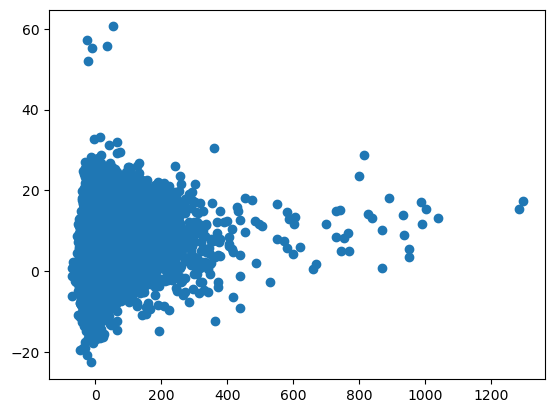

In [210]:
plt.scatter(y_test,y_pred)

In [212]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 2444.76
RMSE: 49.44
